## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. 

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` reading `ab_data.csv` data. And storing it in `df`.  

a. Reading in the dataset and taking a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b.The number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
print('The number of unique users in the dataset: ',df['user_id'].nunique())

The number of unique users in the dataset:  290584


d. The proportion of users converted.

In [5]:
print('The proportion of user converted: {0:.2f}%'.format(df[df['converted']==1].shape[0]*100/df.shape[0]))

The proportion of user converted: 11.97%


e. The number of times the `new_page` and `treatment` don't match.

In [6]:
print('The number of times the new_page and treatment don\'t match: ',df[(df['group']=='treatment')&(df['landing_page']!='new_page')]['group'].count()+df[(df['group']!='treatment')&(df['landing_page']=='new_page')]['group'].count())

The number of times the new_page and treatment don't match:  3893


f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df[(df['group'] == 'treatment') == (df['landing_page'] == 'new_page')]

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [10]:
df2.shape[0]

290585

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 = df2.drop(1899)

In [14]:
df2.shape[0]

290584

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
print('the probability of an individual converting regardless of the page they receive is: ',df2[df2['converted']==1].shape[0])

the probability of an individual converting regardless of the page they receive is:  34753


b. Given that an individual was in the `control` group, what is the probability they converted?


In [16]:
p_control = df2[(df2['converted']==1)&(df2['group']=='control')].shape[0]/df2[df2['group']=='control'].shape[0]
print('the probability of an individual converting regardless of the page they receive is: {:.2f}%'.format(p_control*100))

the probability of an individual converting regardless of the page they receive is: 12.04%


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
p_treat = df2[(df2['converted']==1)&(df2['group']=='treatment')].shape[0]/df2[df2['group']=='treatment'].shape[0]
print('the probability they converted is: {:.2f}%'.format(p_treat*100))

the probability they converted is: 11.88%


d. What is the probability that an individual received the new page?

In [18]:
print(' the probability that an individual received the new page is: {:.2f}%'.format(100*df2[df2['landing_page']=='new_page'].shape[0]/df2.shape[0]))

 the probability that an individual received the new page is: 50.01%


e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

`No, it looks like that the two groups are almost equal, and the proportions of converting are same if not higher incase of the old design.`

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{old} -p_{new} \geq 0 $$
$$H_1: p_{old} -p_{new} < 0 $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
p_new = df2[df2['converted']==1].shape[0]/df2.shape[0]
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = p_new
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
n_new = df2[df2['group']=='treatment'].shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
n_old = df2[df2['group']=='control'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
sum(np.random.binomial(1, p_new, n_new) == 1)/n_new

0.12085197164682403

In [24]:
 # we use numpy random binomial in simulation because simulating of big sample size will take long time.

new_page_converted = np.random.binomial(1, p_new, n_new)


#checking a sample
print(new_page_converted)

#checking the count of converted
print(sum(new_page_converted))

#checking the sum of old
new_page_converted.shape

[1 1 1 ..., 0 0 0]
17334


(145310,)

In [25]:
#probability of converting of old page individuals.

p_new_sim = sum(new_page_converted)/n_new
print('probability of converting of old page individuals: {:.4f}%'.format(100*p_new_sim))

probability of converting of old page individuals: 11.9290%


f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.binomial(1, p_old, n_old)

#checking a sample.
print(old_page_converted)

#checking the count of converted
print(sum(old_page_converted))

#checking the sum of old
old_page_converted.shape

[0 0 0 ..., 0 0 0]
17291


(145274,)

In [27]:
#probability of converting of old page individuals.
p_old_sim = sum(old_page_converted)/n_old
print('probability of converting of old page individuals: {:.4f}%'.format(100*p_old_sim))

probability of converting of old page individuals: 11.9023%


g. $p_{new}$ - $p_{old}$ for the simulated values from part (e) and (f).

In [28]:
p_new_sim-p_old_sim

0.0002664314840068599

h. Creating 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Then Storing all 10,000 values in a NumPy array called **p_diffs**.

In [29]:
p_diffs = []

for i in range(10000):
    
    new_page_converted = np.random.binomial(1, p_new, n_new)
    old_page_converted = np.random.binomial(1, p_old, n_old)
    
    p_new_sim = sum(new_page_converted)/n_old
    
    p_old_sim = sum(old_page_converted)/n_old
    
    p_diffs.append(p_new_sim - p_old_sim)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

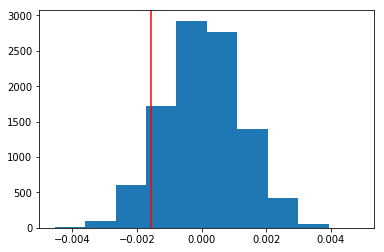

In [30]:
#plotting the p_diffs sampling distribution which is conforming as well with the null hypothesis we have made.
#as well drawing the line of real calculation from the data set to compare.
plt.hist(p_diffs);
plt.axvline(p_treat-p_control, color='r');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
#Getting the p-value of our results:
(np.array(p_diffs)>(p_treat-p_control)).mean()

0.9103

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**`We have computed the p-value of our hypothesis assuming that rate of conversions in the new page are equal to the rate of conversion in the old page, since our type I error was defined at 5%, we couldn't reject the hypothesis since the percentage of error was about 10%`**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
import statsmodels.api as sm

convert_old = df2[(df2['landing_page']=='old_page')&(df2['converted']==1)].shape[0]
convert_new = df2[(df2['landing_page']=='new_page')&(df2['converted']==1)].shape[0]
n_old = df2[df2['landing_page']=='old_page'].shape[0]
n_new = df2[df2['landing_page']=='new_page'].shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [33]:
#showing the values to make sure it is correct:
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

In [34]:
from statsmodels.stats.proportion import proportions_ztest
#value is zero, since null hypothesis is two sided, and diff of both sides = zero

#alternative : str in [‘two-sided’, ‘smaller’, ‘larger’], in our case (𝐻1: 𝑝𝑛𝑒𝑤<𝑝𝑜𝑙𝑑) so we use larger.
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], value = 0,  alternative = 'larger')
print(z_score)
print(p_value)

-1.31092419842
0.905058312759


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

****`the p_value of that method is confirming the previous p_value from the other method, which is a good indication of our calculations and an affirmation to our decision to fail to reject the null hypothesis, while the Z-score indicates how far is our findings from our hypothesis, as it is 1.31 standard deviatation far to the left, we know the magnitude and direction of our findings against the our hypothesis.`****

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**`We can define our regression here as a logistic regression since it defines only two outcomes. being categorical ones, we need to predict only one possible outcome, either is a conversion or no conversion.`**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
#adding intercept column.
df2['intercept']=1

#adding the categorial columns.
df2[['n_ab_page', 'ab_page']]= pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,n_ab_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Using **statsmodels** to instantiate the regression model on the two columns created in part b., then fitting the model using the two columns created in part **b.** to predict whether or not an individual converts. 

In [36]:
log_m = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = log_m.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Providing the summary of your model below, and use it as necessary to answer the following questions.

In [37]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-05-27 19:23 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [38]:
1/np.exp(-0.0150).round(5)

1.0151150632924242


**`For every one point increase in receiving new page, an individual is 1.015% less likely to convert, holding all other variables constant.`**

**`P>|z| for ab_pages indicates that it is not statiscally signficant.`**

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**`The difference between the two tests is in the Hypothesis type, first hypothesis is a one sided test, since the 𝐻0: 𝑝𝑜𝑙𝑑 − 𝑝𝑛𝑒𝑤 ≥ 0 since we are using a significance level of .05, a one-tailed test allots all of our alpha to testing the statistical significance in the one direction of interest. and completely disregarding the possibility of a relationship in the other direction.`**

**`While it is a two tailed test in Part III, so the significance level is distributed in left and right`**



f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

###  Adding more factors can increase the strength of the relation model, however we have to be concerned about a couple of points:
**`1- Predictors should have a noticable correlation or else, they will weaken the model instead.
`**

**`2- We shouldn't use so many predictors, or else it will be over fitted for this instance but not for other instances`**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns -  Provide the statistical output as well as a written response to answer this question.

In [39]:
df_country = pd.read_csv('countries.csv')
df_country.shape
df2 = df2.set_index('user_id').join(df_country.set_index('user_id'))


In [45]:
df2[['CA', 'UK', 'US']] = pd.get_dummies(df2['country'])

In [60]:
log_m2 = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'UK', 'CA']])
results = log_m2.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-05-27 20:13 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
==================================================================

"""

In [54]:
np.exp([-0.0149, 0.0099,  -0.0408])

array([ 0.98521046,  1.00994917,  0.96002111])

**`From our error margin 5%, we can conclude here that including countries factor is statistically insignificant, and doesn't change our earlier conclusion from before.`**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [49]:
df_new = df2
df_new['ab_UK'] = df_new['ab_page'] * df_new['UK']
df_new['ab_CA'] = df_new['ab_page'] * df_new['CA']
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept','ab_page','ab_UK', 'ab_CA']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-05-27 19:45 AIC:              212778.9383
No. Observations:   290584           BIC:              212821.2568
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0183    0.0126    -1.4486  0.1475  -0.0430   0.0064
ab_UK         0.0257    0.0188     1.3634  0.1728  -0.0112   0.0625
ab_CA        -0.0644    0.0384    -1.6788  0.0932  -0.1396   0.0108
==================================================================

"""

In [55]:
np.exp([-0.0149, 0.0099,  -0.0408])

array([ 0.98521046,  1.00994917,  0.96002111])

In [51]:
np.exp([-0.0183, 0.0257,  -0.0644])

array([ 0.98186643,  1.02603309,  0.93762987])

**`After applying interaction factor between countries and each other. Observing the p-value of countries, type of pages being more than 5%, we fail once again to reject the null hypothesis `**

<a id='conclusions'></a>
## Conclusion: 

> After performing AB tests, and logistic regression tests on our model, with all the data that we have, we fail to reject our Null Hypothesis that the old page having better or equal conversion rates as the new page.

> So we declare that the increase in conversions using the New Page is statistical insignfigant.

> Recommendations: 
  a - Reject the new page, and continue with the old layout.
  b - Repeat the test after two month of performance to negate the **Novelty Effect, or the Change Aversion**






In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])